<a href="https://www.kaggle.com/code/irinamaslowski/u-s-patent-phrase-basic-eda?scriptVersionId=97848035" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv
/kaggle/input/cpc-codes/titles.csv


# EDA

## Train dataset

The purpose of this Exploratory Data Analysis (EDA) is first of all to get aquaintance with the data to manipulate in the kaggle challenge ["U.S. Patent Phrase to Phrase Matching"](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview).

In [2]:
# Charging train dataset
train = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv")
print(train.shape)
train.head()

(36473, 5)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [3]:
train.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [4]:
# The maximum width in characters of a column in the repr of a pandas data structure
pd.set_option('display.max_colwidth', None)

In [5]:
train['score'].unique()

array([0.5 , 0.75, 0.25, 0.  , 1.  ])

The 'score' column contains only 5 different score values.

In [6]:
train.groupby('score').count()

,id,anchor,target,context
score,,,,
0.00,7471,7471,7471,7471
0.25,11519,11519,11519,11519
0.50,12300,12300,12300,12300
0.75,4029,4029,4029,4029
1.00,1154,1154,1154,1154


## Score meanings according to [Data Description](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data?select=train.csv)

The scores are in the 0-1 range with increments of 0.25 with the following meanings:

    1.0 - Very close match. This is typically an exact match except possibly for differences in conjugation, quantity (e.g. singular vs. plural), and addition or removal of stopwords (e.g. “the”, “and”, “or”).
    0.75 - Close synonym, e.g. “mobile phone” vs. “cellphone”. This also includes abbreviations, e.g. "TCP" -> "transmission control protocol".
    0.5 - Synonyms which don’t have the same meaning (same function, same properties). This includes broad-narrow (hyponym) and narrow-broad (hypernym) matches.
    0.25 - Somewhat related, e.g. the two phrases are in the same high level domain but are not synonyms. This also includes antonyms.
    0.0 - Unrelated.


Obviously, there are more phrases that are "Synonyms which don’t have the same meaning" than other categories.

In [7]:
train.groupby('score').nunique()

,id,anchor,target,context
score,,,,
0.00,7471,725,6618,104
0.25,11519,727,9286,106
0.50,12300,729,10681,106
0.75,4029,682,3667,104
1.00,1154,470,973,100


In [8]:
train[train['anchor'] == 'abatement'].count()

id         49
anchor     49
target     49
context    49
score      49
dtype: int64

There are more unique elements in "target" and it's logic as one type of anchor or context can have different targets.

# Test Corpus

In [9]:
# Charging 'test' corpus
test = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv")

In [10]:
test.shape

(36, 4)

'test' dataset contains only 36 lines

# Additional Context

As we can see, the phrases in 'train' dataset are very short. The NLP tasks on short phrases are the most challenging ones. We can find more contexte in another database "Cooperative Patent Classification Codes Meaning" ("cpc-codes") added by @xhlulu which is available on Kaggle. 

In [11]:
titles = pd.read_csv("../input/cpc-codes/titles.csv")
print(titles.shape)
titles.head()

(260476, 7)


,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTING; TRAPPING; FISHING,A,1.0,NaN,NaN,NaN
2,A01B,"SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS, DETAILS, OR ACCESSORIES OF AGRICULTURAL MACHINES OR IMPLEMENTS, IN GENERAL (making or covering furrows or holes for sowing, planting, or manuring A01C5/00; soil working for engineering purposes E01, E02, E21; {measuring areas for agricultural purposes G01B})",A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 {; machines for working soil A01B35/00; making hand tools B21D}),A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3/02)},A,1.0,B,1.0,2.0


The 'cpc-codes' dataset provides more context in "title" colomn. We can use it to inrich the 'train' dataset. Let's go into more details of this dataset.

In [12]:
titles[titles['section'] == 'A']['code'].unique

<bound method Series.unique of 0                A
1              A01
2             A01B
3         A01B1/00
4         A01B1/02
           ...    
29645    A63K3/046
29646    A63K99/00
29647          A99
29648         A99Z
29649    A99Z99/00
Name: code, Length: 29650, dtype: object>

One section can contain sub-  and sub- sub- sections.

'pandas-profiling' library allows to get a fast EDA with a nice layout. However, one should be careful in interpreting the obtained results. Depending on the dataset some part of analysis can be sensless.

In [13]:
!pip install pandas-profiling

In [14]:
import pandas_profiling
#Generating PandasProfiling Report
report = pandas_profiling.ProfileReport(titles)

In [15]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Wordcloud

A wordcloud allows us to perseive in a glance the main semantic trends in the dataset. The words that appear bigger than others in the cloud are the words that have the biggest occurances in the dataset.

In [16]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [17]:
cloud_txt = ' '.join(train['target'].values.tolist())

In [18]:
wc = WordCloud()

In [19]:
wc.generate(cloud_txt)

In [20]:
wc.to_file('output.png')

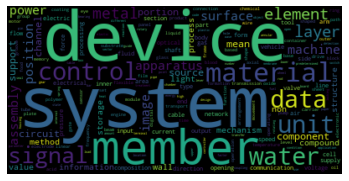

In [21]:
%matplotlib inline
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Based on wordcloud, we can suppose that the 'train' dataset contains phrases describing different devices, systems and materials. Let's make a wordcloud for the 'cpc-codes' dataset.

In [22]:
cloud_titles = ' '.join(titles['title'].values.tolist())

As the 'cpc-codes' dataset is bigger than the 'train' one, let's make the wordcloud image bigger.

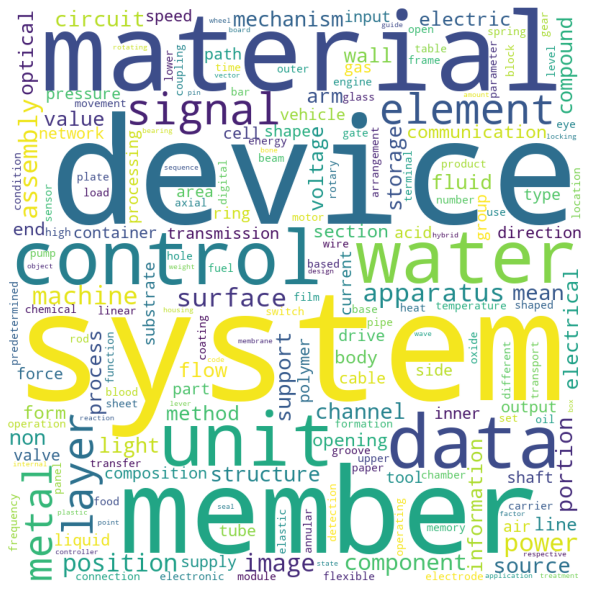

In [23]:
wordcloud = WordCloud(width = 800, 
                      height = 800,
                      background_color ='white',
                      min_font_size = 10,
                      ).generate(cloud_txt) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

The general topic remains the same. The patents give the technical description of different devices, systems and materials. The patent code descriptions give precisions and details.

*The EDA step is finished. The next step is training and testing different models.*